In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tifffile import imread
from skimage.transform import resize
from scipy.ndimage import median_filter
from skimage.filters import gaussian
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os
import random

# Set seed

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Config
CONFIG = {
    "resize_shape": (64, 64),
    "window": 10,
    "future_steps": 1,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "save_vis_dir": os.path.join(os.path.expanduser("~"), "Desktop", "LSTM_Predictions")
}
os.makedirs(CONFIG["save_vis_dir"], exist_ok=True)

In [33]:
# Preprocessing

def denoise_gaussian_median(frame, median_size=3, gaussian_sigma=1.0):
    return gaussian(median_filter(frame, size=median_size), sigma=gaussian_sigma)

def load_tif_sequences(path, window=10, future_steps=1):
    stack = imread(path)
    stack_denoised = np.array([denoise_gaussian_median(f) for f in stack])
    stack_resized = np.array([resize(f, CONFIG["resize_shape"]) for f in stack_denoised])
    norm_stack = (stack_resized - stack_resized.min()) / (stack_resized.max() - stack_resized.min())
    norm_stack = norm_stack * 2 - 1

    sequences = []
    for i in range(0, len(norm_stack) - window - future_steps + 1):
        seq = norm_stack[i:i+window]  # (T, H, W)
        target = norm_stack[i+window:i+window+future_steps]  # (F, H, W)
        sequences.append((seq, target))
    return sequences

In [34]:
# Dataset

class PatchSequenceDataset(Dataset):
    def __init__(self, sequences, shape=(64, 64)):
        self.sequences = sequences
        self.shape = shape
        self.pos_enc = self._generate_positional_encodings(shape)

    def _generate_positional_encodings(self, shape):
        H, W = shape
        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
        pos = torch.stack((grid_y, grid_x), dim=-1).float()  # (H, W, 2)
        pos = pos / torch.tensor([H - 1, W - 1])  # normalize to [0, 1]
        return pos  # (H, W, 2)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq, target = self.sequences[idx]
        T = seq.shape[0]
        F = target.shape[0]
        H, W = self.shape
        pos_enc = self.pos_enc.permute(2, 0, 1).unsqueeze(0).repeat(T, 1, 1, 1)  # (T, 2, H, W)
        seq = torch.tensor(seq.reshape(T, H, W), dtype=torch.float32).unsqueeze(1)  # (T, 1, H, W)
        seq_with_pos = torch.cat([seq, pos_enc], dim=1)  # (T, 3, H, W)
        return seq_with_pos, torch.tensor(target.reshape(F, H, W), dtype=torch.float32)


In [38]:
# Model

class CNN_LSTM_baseline(nn.Module):
    def __init__(self, patch_size=8, image_size=(64, 64), hidden_dim=256, lstm_layers=2, dropout=0.1, future_steps=1):
        super().__init__()
        self.patch_size = patch_size
        self.image_size = image_size
        self.future_steps = future_steps
        self.num_patches = (image_size[0] // patch_size) * (image_size[1] // patch_size)

        self.cnn_encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.patch_feat_dim = 32 * patch_size * patch_size
        self.linear_encoder = nn.Linear(self.patch_feat_dim, 128)

        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False
        )

        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.attn_norm = nn.LayerNorm(hidden_dim)

        # ✅ Fully linear decoder (no ConvTranspose2d or unflattening)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, patch_size * patch_size)
        )

    def forward(self, x):  # x: [B, T, 3, H, W]
        B, T, C, H, W = x.size()
        P = self.patch_size

        x = x.view(B * T, C, H, W)
        features = self.cnn_encoder(x)  # (B*T, C_out, H, W)
        features = features.unfold(2, P, P).unfold(3, P, P)  # (B*T, C, H//P, W//P, P, P)
        features = features.permute(0, 2, 3, 1, 4, 5).contiguous()  # (B*T, H//P, W//P, C, P, P)
        features = features.view(B, T, -1, self.patch_feat_dim)  # (B, T, num_patches, patch_feat)

        outputs = []
        for p in range(features.size(2)):
            patch_seq = features[:, :, p, :]  # (B, T, feat)
            encoded = self.linear_encoder(patch_seq.view(-1, patch_seq.size(-1))).view(B, T, -1)
            lstm_out, _ = self.lstm(encoded)
            attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
            attn_out = self.attn_norm(attn_out)

            # ✅ Decode each patch into shape (P, P)
            decoded = self.decoder(attn_out[:, -1, :])  # (B, P*P)
            decoded = decoded.view(B, P, P)  # (B, P, P)
            outputs.append(decoded)

        outputs = torch.stack(outputs, dim=2)  # (B, num_patches, P, P)
        outputs = outputs.view(B, H // P, W // P, P, P)
        outputs = outputs.permute(0, 1, 3, 2, 4).contiguous().view(B, H, W)
        return outputs.unsqueeze(1)  # (B, 1, H, W)


# Utility functions

def compute_metrics(preds, targets):
    preds = np.array(preds)
    targets = np.array(targets)
    mae = mean_absolute_error(targets.flatten(), preds.flatten())
    corr, _ = pearsonr(targets.flatten(), preds.flatten())
    return mae, corr

def visualize_preds(preds, targets, shape=(64, 64), save_dir=None, prefix="LSTM_baseline"):
    preds = np.array(preds)
    targets = np.array(targets)
    num_samples = min(3, len(preds))
    F = preds.shape[1]

    for i in range(num_samples):
        for t in range(F):
            try:
                pred = preds[i, t]
                target = targets[i, t]
                diff = np.abs(pred - target)

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(pred, cmap='viridis')
                axes[0].set_title("Predicted Frame")
                axes[1].imshow(target, cmap='viridis')
                axes[1].set_title("Ground Truth")
                axes[2].imshow(diff, cmap='hot')
                axes[2].set_title("Abs Error")
                for ax in axes:
                    ax.axis('off')
                plt.tight_layout()

                if save_dir:
                    filename = os.path.join(save_dir, f"{prefix}_pred_{i}_t{t}.png")
                    plt.savefig(filename)
                    print(f"✅ Saved: {filename}")
                else:
                    plt.show()

                plt.close()
            except Exception as e:
                print(f"❌ Error saving frame {i}, time {t}: {e}")


In [39]:
# Training and Evaluation

def train_lstm_baseline(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_lstm_baseline(model, loader, loss_fn, device, return_preds=False):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            if return_preds:
                preds.extend(out.cpu().numpy())
                targets.extend(y.cpu().numpy())
    if return_preds:
        return total_loss / len(loader), preds, targets
    return total_loss / len(loader)

# Utility functions

def compute_metrics(preds, targets):
    preds = np.array(preds)
    targets = np.array(targets)
    mae = mean_absolute_error(targets.flatten(), preds.flatten())
    corr, _ = pearsonr(targets.flatten(), preds.flatten())
    return mae, corr

def visualize_preds(preds, targets, shape=(64, 64), save_dir=None, prefix="LSTM_baseline"):
    preds = np.array(preds)
    targets = np.array(targets)
    num_samples = min(3, len(preds))
    F = preds.shape[1]

    for i in range(num_samples):
        for t in range(F):
            try:
                pred = preds[i, t]
                target = targets[i, t]
                diff = np.abs(pred - target)

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(pred, cmap='viridis')
                axes[0].set_title("Predicted Frame")
                axes[1].imshow(target, cmap='viridis')
                axes[1].set_title("Ground Truth")
                axes[2].imshow(diff, cmap='hot')
                axes[2].set_title("Abs Error")
                for ax in axes:
                    ax.axis('off')
                plt.tight_layout()

                if save_dir:
                    filename = os.path.join(save_dir, f"{prefix}_pred_{i}_t{t}.png")
                    plt.savefig(filename)
                    print(f"✅ Saved: {filename}")
                else:
                    plt.show()

                plt.close()
            except Exception as e:
                print(f"❌ Error saving frame {i}, time {t}: {e}")



In [40]:
# Main

if __name__ == "__main__":
    file_paths = [
        "C:/Users/Platypus/Documents/CellNet/Real_Time_CS_Experiment-1093.tif",
        "C:/Users/Platypus/Documents/CellNet/Flow prior to chemical stimulation_Figure6C.tif",
        "C:/Users/Platypus/Documents/CellNet/Figure8.tif",
        "C:/Users/Platypus/Documents/CellNet/5uM_per_litre_Figure6_ChemicalStimulation.tif",
        "C:/Users/Platypus/Documents/CellNet/Cell Knocked_Figure7.tif"
    ]

    all_seqs = []
    for path in file_paths:
        all_seqs.extend(load_tif_sequences(path, window=CONFIG["window"]))

    train_val, test = train_test_split(all_seqs, test_size=0.15, random_state=42)
    train_seqs, val_seqs = train_test_split(train_val, test_size=0.2, random_state=42)

    train_loader = DataLoader(PatchSequenceDataset(train_seqs, shape=CONFIG["resize_shape"]), batch_size=8, shuffle=True)
    val_loader = DataLoader(PatchSequenceDataset(val_seqs, shape=CONFIG["resize_shape"]), batch_size=8)
    test_loader = DataLoader(PatchSequenceDataset(test, shape=CONFIG["resize_shape"]), batch_size=8)

    model = CNN_LSTM_baseline(image_size=CONFIG["resize_shape"]).to(CONFIG["device"])

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()

    best_val = float('inf')
    patience = 5
    counter = 0

    for epoch in range(50):
        train_loss = train_lstm_baseline(model, train_loader, optimizer, loss_fn, CONFIG["device"])
        val_loss = evaluate_lstm_baseline(model, val_loader, loss_fn, CONFIG["device"])
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "best_lstm_patch.pt")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_lstm_patch.pt"))
    test_loss, preds, targets = evaluate_lstm_baseline(model, test_loader, loss_fn, CONFIG["device"], return_preds=True)

    mae, corr = compute_metrics(preds, targets)

    print(f"\n✅ Final LSTM_baseline Patch Model:")
    print(f"  - L1 Loss: {test_loss:.4f}")
    print(f"  - MAE:     {mae:.4f}")
    print(f"  - Corr:    {corr:.4f}")

    pred_var = np.var(np.stack(preds), axis=0).mean()
    print(f"🔍 Mean variance across predicted pixels: {pred_var:.6f}")

    for i in range(3):
        try:
            visualize_preds(preds, targets, shape=CONFIG["resize_shape"], save_dir=CONFIG["save_vis_dir"])
        except Exception as e:
            print(f"❌ Error saving frame {i}: {e}")


Epoch 1 | Train Loss: 0.0494 | Val Loss: 0.0305
Epoch 2 | Train Loss: 0.0312 | Val Loss: 0.0276
Epoch 3 | Train Loss: 0.0272 | Val Loss: 0.0278
Epoch 4 | Train Loss: 0.0241 | Val Loss: 0.0224
Epoch 5 | Train Loss: 0.0215 | Val Loss: 0.0215
Epoch 6 | Train Loss: 0.0195 | Val Loss: 0.0189
Epoch 7 | Train Loss: 0.0174 | Val Loss: 0.0170
Epoch 8 | Train Loss: 0.0156 | Val Loss: 0.0170
Epoch 9 | Train Loss: 0.0146 | Val Loss: 0.0134
Epoch 10 | Train Loss: 0.0138 | Val Loss: 0.0130
Epoch 11 | Train Loss: 0.0128 | Val Loss: 0.0123
Epoch 12 | Train Loss: 0.0119 | Val Loss: 0.0119
Epoch 13 | Train Loss: 0.0115 | Val Loss: 0.0119
Epoch 14 | Train Loss: 0.0109 | Val Loss: 0.0104
Epoch 15 | Train Loss: 0.0104 | Val Loss: 0.0105
Epoch 16 | Train Loss: 0.0099 | Val Loss: 0.0102
Epoch 17 | Train Loss: 0.0096 | Val Loss: 0.0096
Epoch 18 | Train Loss: 0.0094 | Val Loss: 0.0090
Epoch 19 | Train Loss: 0.0092 | Val Loss: 0.0095
Epoch 20 | Train Loss: 0.0089 | Val Loss: 0.0093
Epoch 21 | Train Loss: 0.0087

C:\Users\Platypus\AppData\Local\Temp\ipykernel_23396\794076611.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lstm_patch.pt"))



✅ Final LSTM_baseline Patch Model:
  - L1 Loss: 0.0062
  - MAE:     0.0061
  - Corr:    0.9408
🔍 Mean variance across predicted pixels: 0.002808
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\LSTM_baseline_pred_0_t0.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\LSTM_baseline_pred_1_t0.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\LSTM_baseline_pred_2_t0.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\LSTM_baseline_pred_0_t0.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\LSTM_baseline_pred_1_t0.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\LSTM_baseline_pred_2_t0.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\LSTM_baseline_pred_0_t0.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\LSTM_baseline_pred_1_t0.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\LSTM_baseline_pred_2_t0.png


In [46]:
# Multi-step Prediction (Extrapolation)

import shutil

def predict_multiple_future_frames(model, initial_seq, steps, device):
    model.eval()
    preds = []
    current_seq = initial_seq.clone().to(device)  # (1, T, 3, H, W)

    with torch.no_grad():
        for step in range(steps):
            next_frame = model(current_seq)  # (1, 1, H, W)
            preds.append(next_frame.cpu().squeeze().numpy())  # (H, W)

            # Prepare next sequence
            new_frame = next_frame.unsqueeze(2).repeat(1, 1, 3, 1, 1)  # (1, 1, 3, H, W)
            current_seq = torch.cat([current_seq[:, 1:], new_frame], dim=1)

    return np.stack(preds, axis=0)  # (steps, H, W)


# Get one example from test set
sample_seq, _ = test_loader.dataset[0]  # (T, 3, H, W)
sample_seq = sample_seq.unsqueeze(0)  # (1, T, 3, H, W)

future_preds = predict_multiple_future_frames(model, sample_seq, steps=5, device=CONFIG["device"])

# Save predictions
future_save_dir = os.path.join(CONFIG["save_vis_dir"], "Future_ConvLSTM_with_Attention")
shutil.rmtree(future_save_dir, ignore_errors=True)
os.makedirs(future_save_dir, exist_ok=True)

for t, pred in enumerate(future_preds):
    plt.imshow(pred, cmap='viridis')
    plt.axis('off')
    plt.title(f"Predicted t+{t+1}")
    save_path = os.path.join(future_save_dir, f"future_pred_t{t+1}.png")
    plt.savefig(save_path)
    print(f"✅ Saved: {save_path}")
    plt.close()


✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\Future_ConvLSTM_with_Attention\future_pred_t1.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\Future_ConvLSTM_with_Attention\future_pred_t2.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\Future_ConvLSTM_with_Attention\future_pred_t3.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\Future_ConvLSTM_with_Attention\future_pred_t4.png
✅ Saved: C:\Users\Platypus\Desktop\LSTM_Predictions\Future_ConvLSTM_with_Attention\future_pred_t5.png


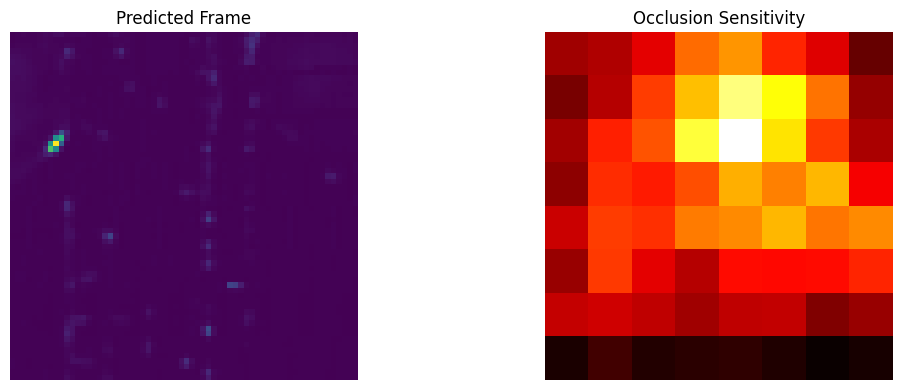

In [43]:
# Saliency & Input Sensitivity
def occlusion_sensitivity(model, input_seq, device, patch_size=8):
    model.eval()
    B, T, C, H, W = input_seq.shape
    base_pred = model(input_seq.to(device)).detach().cpu().squeeze().numpy()  # (H, W)

    heatmap = np.zeros((H, W))

    for y in range(0, H, patch_size):
        for x in range(0, W, patch_size):
            occluded_seq = input_seq.clone()
            occluded_seq[:, :, :, y:y+patch_size, x:x+patch_size] = 0  # zero-out patch

            with torch.no_grad():
                occluded_pred = model(occluded_seq.to(device)).detach().cpu().squeeze().numpy()


            diff = np.abs(occluded_pred - base_pred).mean()
            heatmap[y:y+patch_size, x:x+patch_size] = diff

    return base_pred, heatmap


# Get one sequence from test set
sample_seq, _ = test_loader.dataset[0]
sample_seq = sample_seq.unsqueeze(0).to(CONFIG["device"])  # (1, T, 3, H, W)

base_pred, saliency_map = occlusion_sensitivity(model, sample_seq, device=CONFIG["device"])

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(base_pred, cmap="viridis")
plt.title("Predicted Frame")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap="hot")
plt.title("Occlusion Sensitivity")
plt.axis("off")
plt.tight_layout()
plt.show()


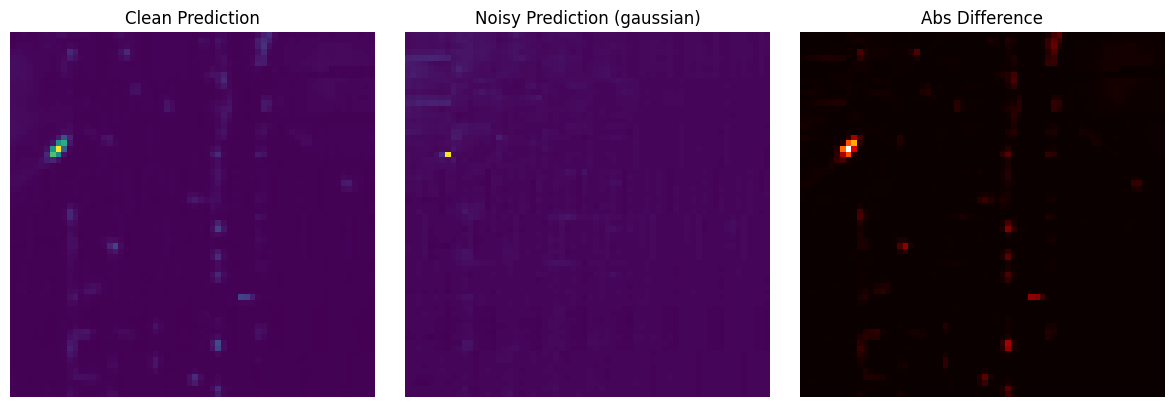

✅ Mean abs diff (noise impact): 0.010364


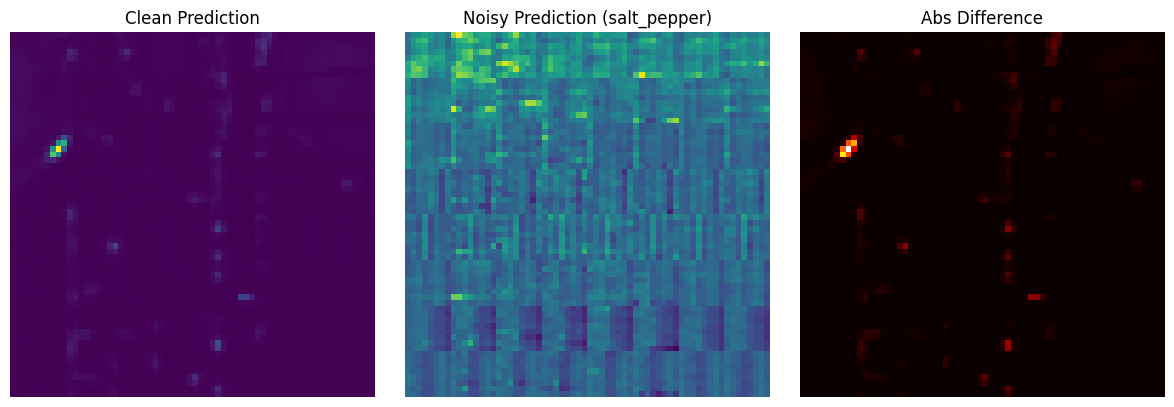

✅ Mean abs diff (noise impact): 0.010892


In [ ]:
#Noise Robustness

def add_gaussian_noise(img, mean=0.0, std=0.1):
    noise = torch.randn_like(img) * std + mean
    return torch.clamp(img + noise, -1, 1)

def add_salt_and_pepper_noise(img, prob=0.05):
    noisy = img.clone()
    rand = torch.rand_like(img)
    noisy[rand < (prob / 2)] = -1  # salt
    noisy[rand > 1 - (prob / 2)] = 1  # pepper
    return noisy

def test_noise_robustness(model, sample_seq, noise_fn, noise_name="gaussian"):
    model.eval()
    with torch.no_grad():
        clean_pred = model(sample_seq).cpu().squeeze().numpy()
        noisy_seq = noise_fn(sample_seq)
        noisy_pred = model(noisy_seq).cpu().squeeze().numpy()

    diff = np.abs(clean_pred - noisy_pred)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(clean_pred, cmap="viridis")
    plt.title("Clean Prediction")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_pred, cmap="viridis")
    plt.title(f"Noisy Prediction ({noise_name})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(diff, cmap="hot")
    plt.title("Abs Difference")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    print(f"✅ Mean abs diff (noise impact): {diff.mean():.6f}")

sample_seq, _ = test_loader.dataset[0]
sample_seq = sample_seq.unsqueeze(0).to(CONFIG["device"])

# Test Gaussian Noise
test_noise_robustness(model, sample_seq, lambda x: add_gaussian_noise(x, std=0.1), "gaussian")

# Test Salt & Pepper Noise
test_noise_robustness(model, sample_seq, lambda x: add_salt_and_pepper_noise(x, prob=0.05), "salt_pepper")


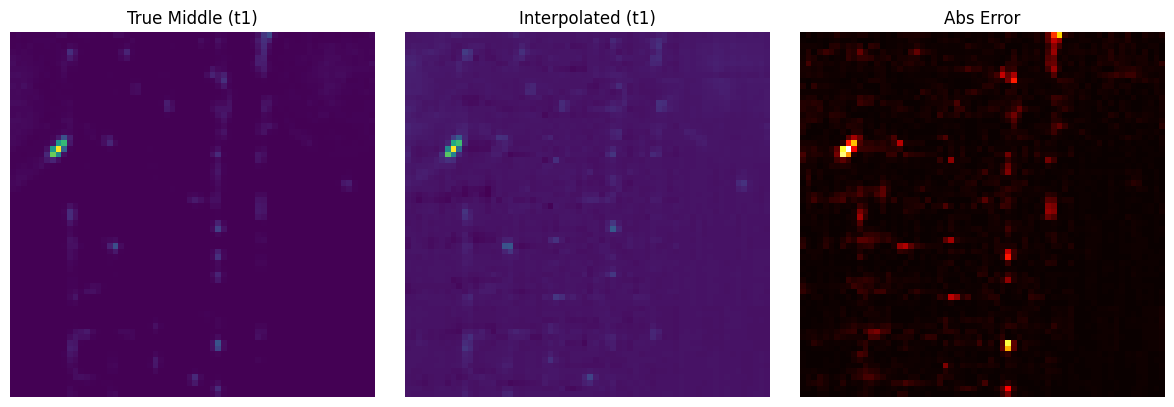

✅ MAE: 0.009690


In [45]:
interpolation_sample, _ = test_loader.dataset[0]  # (T, 3, H, W)
t0 = interpolation_sample[0].unsqueeze(0)  # (1, 3, H, W)
t2 = interpolation_sample[2].unsqueeze(0)  # (1, 3, H, W)

# Form fake sequence: [t0, ?, t2] → predict center (we’ll use t0 and t2 as context)
context_seq = torch.stack([t0.squeeze(0), t2.squeeze(0)]).unsqueeze(0).to(CONFIG["device"])  # (1, 2, 3, H, W)

model.eval()
with torch.no_grad():
    interpolated = model(context_seq).cpu().squeeze().numpy()

ground_truth_t1 = interpolation_sample[1][0].cpu().numpy()  # Only calcium channel

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(ground_truth_t1, cmap='viridis')
plt.title("True Middle (t1)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(interpolated, cmap='viridis')
plt.title("Interpolated (t1)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.abs(interpolated - ground_truth_t1), cmap='hot')
plt.title("Abs Error")
plt.axis("off")
plt.tight_layout()
plt.show()

print(f"✅ MAE: {np.abs(interpolated - ground_truth_t1).mean():.6f}")
